# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Missing/useful imports
!pip install ipywidgets
from IPython.display import display, clear_output

# Define transforms
live_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.1296,0.3071)])
live_transform = transforms.ToTensor()
visualization_transform = transforms.ToTensor()

# Create training set and define training data, validation data, test_data, and visualization data
full_training_data = torchvision.datasets.MNIST("data",True,live_transform,download=True)
working_training_data = torch.utils.data.Subset(full_training_data,list(range(0,49999)))
validation_data = torch.utils.data.Subset(full_training_data,list(range(50000,59999)))
test_data = torchvision.datasets.MNIST("data",False,live_transform,download=True)
visualization_data = torchvision.datasets.MNIST("data",False,visualization_transform,download=True)

# Create test set and define training, validation, test, and visualization dataloaders
training_dataloader = torch.utils.data.DataLoader(working_training_data, batch_size = 500, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size = 1000, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = len(test_data))
visualization_dataloader = torch.utils.data.DataLoader(visualization_data, batch_size = 50)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 137 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 384 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 5.6 MB/s eta 0:00:01


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Determine mean and std dev of training data
preProcess_iter = iter(training_dataloader)
preProcess_inputs, preProcess_labels = next(preProcess_iter)
print(f'Mean data value in training data = {torch.mean(preProcess_inputs).item()}')
print(f'Standard deviation of training data values = {torch.std(preProcess_inputs).item()}')

Mean data value in training data = 0.13450689613819122
Standard deviation of training data values = 0.31237152218818665


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I normalized the intensity according to the guidance here:<br>https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    print(len(batch))
    labels = batch[1][0:5]
    images = batch[0][0:5]
    print(len(images))
    for i in range(5):
        print(int(labels[i].detach()))
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Image size: torch.Size([1, 28, 28])
2
5
7


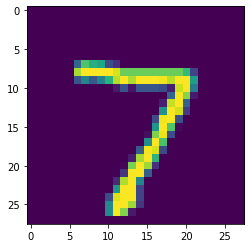

2


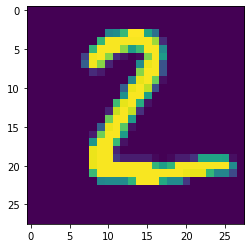

1


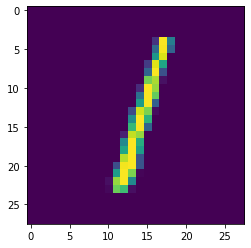

0


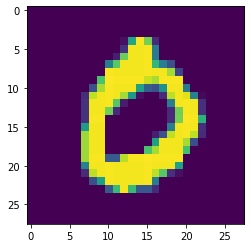

4


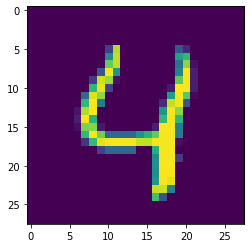

In [5]:
# Explore data
print(f"Image size: {(iter(training_dataloader).next()[0][0]).shape}")
show5(visualization_dataloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
# Network definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.tanh
        self.layer1 = nn.Linear(28 * 28, 784*5)
        self.layer2 = nn.Linear(784*5,784*4)
        self.layer3 = nn.Linear(784*4,784*3)
        self.layer4 = nn.Linear(784*3,784*2)
        self.layer5 = nn.Linear(784*2,10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))
        return x

# Instantiate the model
net = Net()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Hyperparameter container
class Hyperparameters:
    def __init__ (self,optimizer,criterion):
        self.optimizer = optimizer
        self.criterion = criterion

hype_initial = Hyperparameters( \
    torch.optim.Adam(net.parameters(),lr=0.0001), \
    nn.CrossEntropyLoss()
    )


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Stopping criteria.  Training stops if validation loss more than 1+validation_significant_gain times the lowest loss
# for more than validation_stop_hysteresis consecutive validations
class StoppingCriteria:
    def __init__(self, max_epochs, validation_interval, validation_significant_gain, validation_stop_hysteresis):
        self.max_epochs = max_epochs
        self.validation_interval = validation_interval
        self.validation_significant_gain = validation_significant_gain
        self.validation_stop_hysteresis = validation_stop_hysteresis

stopping_initial = StoppingCriteria(3,20,.75,5)

Plot the training loss (and validation loss/accuracy, if recorded).

In [9]:
# Visualization Helpers
train_loss_title = 'Training Loss'
train_acc_title = 'Training Accuracy'
val_loss_title = 'Validation Loss'
val_acc_title = 'Validation Accuracy'
train_spec_title = 'Training Output Spectrum'
val_spec_title = 'Validation Output Spectrum'
plot_title_props = {'fontsize':16,'fontweight':'bold'}

def prepare_plot(axs,title):
    axs.set_title(title,{'fontsize':16,'fontweight':'bold'},pad=10)
    axs.set_xticks([])
    axs.set_xticklabels([])
    
# Dashboard Class
class TrainingDashboard:
    def __init__(self):
        self.fig, self.axs = plt.subplots(3, 2, \
                                          squeeze = True, \
                                          constrained_layout = True, \
                                          figsize=(24,18), \
                                          gridspec_kw={'wspace': 0.15, 'hspace': 0.08})
        
        self.train_loss_plot = self.axs[0][0]
        self.train_acc_plot = self.axs[0][1]
        self.val_loss_plot = self.axs[1][0]
        self.val_acc_plot = self.axs[1][1]
        self.train_spec_plot = self.axs[2][0]
        self.val_spec_plot = self.axs[2][1]
        
        self.train_loss_history = []
        self.train_accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        
        plt.show()
    
    def repaint(self):
        # Command and allow redraw
        # https://medium.com/@shahinrostami/jupyter-notebook-and-updating-plots-f1ec4cdc354b
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.3)
    
    def update_training(self,training_loss,training_acc,output_preds):
        
        # Update trace data
        self.train_loss_history.append(training_loss)
        self.train_accuracy_history.append(training_acc)
        
        # Indicate latest and extrema in titles
        self.train_loss_plot.set_title( \
                            f'{train_loss_title} (Last: {training_loss:.3f}, Min: {min(self.train_loss_history):.3f})', \
                            plot_title_props, pad = 10 \
                                      )
        
        self.train_acc_plot.set_title( \
                            f'{train_acc_title} (Last: {training_acc:.1f}%, Max: {max(self.train_accuracy_history):.1f}%)', \
                            plot_title_props, pad = 10 \
                                     )
        
        # Update plots
        self.train_loss_plot.plot(self.train_loss_history)
        self.train_acc_plot.plot(self.train_accuracy_history)
        self.train_spec_plot.clear()
        self.train_spec_plot.set_title(train_spec_title,plot_title_props,pad=10)
        self.train_spec_plot.hist(output_preds)
        
        self.repaint()

    def update_validation(self,validation_loss,validation_acc,output_preds):
        # Update trace data
        self.val_loss_history.append(validation_loss)
        self.val_accuracy_history.append(validation_acc)
        
        # Indicate latest and extrema in titles
        self.val_loss_plot.set_title( \
                                f'{val_loss_title} (Last: {validation_loss:.3f}, Min: {min(self.val_loss_history):.3f})', \
                                plot_title_props, pad = 10 \
                                    )
        
        self.val_acc_plot.set_title( \
                                f'{val_acc_title} (Last: {validation_acc:.1f}%, Max: {max(self.val_accuracy_history):.1f}%)', \
                                plot_title_props, pad = 10 \
                                   )
        
        # Update plots
        self.val_loss_plot.plot(self.val_loss_history)
        self.val_acc_plot.plot(self.val_accuracy_history)
        self.val_spec_plot.clear()
        self.val_spec_plot.hist(output_preds)
        self.val_spec_plot.set_title(val_spec_title,plot_title_props,pad = 10)
            
        self.repaint()

    def update_epoch(self,current_epoch):
        self.fig.suptitle(f'Epoch {current_epoch}',fontsize = 20, fontweight ='bold')
        
    def report_stopping(self):
        self.fig.suptitle(f'Stopping criteria met',fontsize = 20, fontweight ='bold')

In [10]:
# Training routine
def train_model(net, dashbrd, hype_param, stop_crit, train_loader, val_loader):

    least_validation_loss = float("inf")
    validation_interval_counter = 0
    validation_stop_counter = 0
    val_iter = iter(val_loader)
    stopping_training = False
    
    for epoch in range(stop_crit.max_epochs):
        
        net.train()
        train_loss = 0.0
        train_correct = 0
        
        for i, train_data in enumerate(train_loader):
            # data is a list of [inputs, labels]
            train_inputs, train_labels = train_data

            # Zero out the gradients of the optimizer
            hype_param.optimizer.zero_grad()

            # Get the outputs of your model and compute your loss
            train_outputs = net(train_inputs)
            train_loss = hype_param.criterion(train_outputs,train_labels)
            
            # Compute the accuracy
            _, train_preds = torch.max(train_outputs.data, 1)
            train_correct = (train_preds == train_labels).sum().item()
            
            # Update visualization and record data
            dashbrd.update_training(train_loss.item(),(100*train_correct)/len(train_labels),train_preds.tolist())
            
            # Compute the loss gradient using the backward method and have the optimizer take a step
            train_loss.backward()
            hype_param.optimizer.step()
            
            # Perform validation run if is time
            validation_interval_counter += 1
            if validation_interval_counter >= stop_crit.validation_interval:
                validation_interval_counter = 0
                val_loss = 0.0
                val_correct = 0
                net.eval()
                
                # Get validation batch and evaluate model
                # Need try block to handle iterator terminating. See
                # https://github.com/pytorch/pytorch/issues/1917#issuecomment-433698337
                try:
                    val_inputs, val_labels = next(val_iter)
                except StopIteration:
                    val_iter = iter(val_loader)
                    val_inputs, val_labels = next(val_iter)
                
                # Evaluate validation batch outputs against labels
                val_outputs = net(val_inputs)
                val_loss = hype_param.criterion(val_outputs, val_labels)

                # Compute the accuracy
                _, val_preds = torch.max(val_outputs.data, 1)
                val_correct = (val_preds == val_labels).sum().item()
                
                # Update visualization and record data
                dashbrd.update_validation(val_loss.item(),(100*val_correct)/len(val_labels),val_preds.tolist())
                
                # Stopping criteria evaluation
                if val_loss < least_validation_loss:
                    least_validation_loss = val_loss
                    validation_stop_counter = 0
                elif (val_loss/least_validation_loss) >= (1+stop_crit.validation_significant_gain):
                    validation_stop_counter += 1
                else:
                    validation_stop_counter = 0
                if validation_stop_counter >= stop_crit.validation_stop_hysteresis:
                    stopping_training = True
                    break
                
                # Cleanup after validation
                net.train()
        
        if stopping_training == True:
            break
        
        dashbrd.update_epoch(epoch+2)
    
    # Report end
    dashbrd.report_stopping()
        

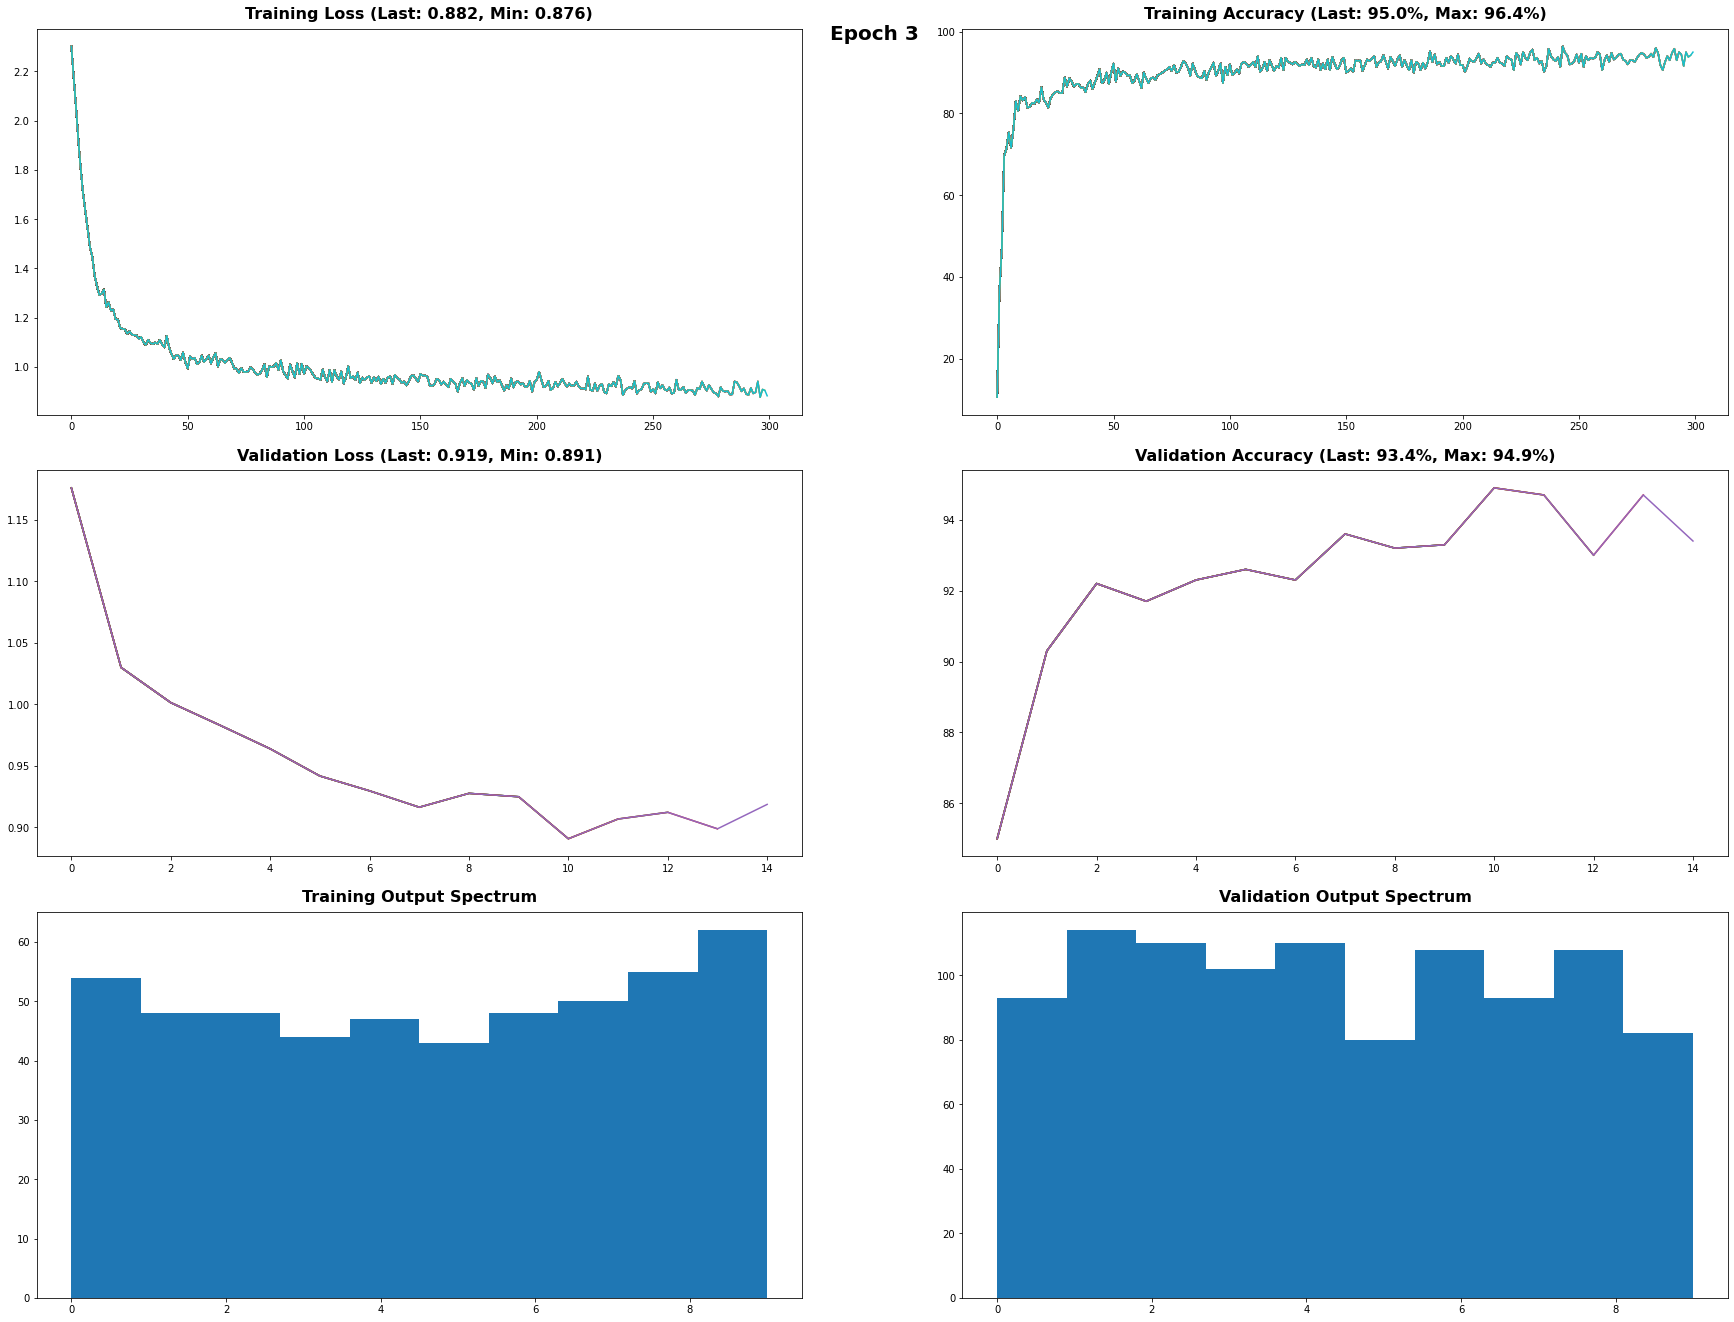

In [11]:
# Train model
train_model(net, TrainingDashboard(), hype_initial, stopping_initial, training_dataloader, validation_dataloader)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
def test_model(net, hype_param, test_dataloader):
    test_iter = iter(test_dataloader)
    test_inputs, test_labels = next(test_iter)
    net.eval()
    test_outputs = net(test_inputs)
    test_loss = hype_param.criterion(test_outputs,test_labels)
    _, test_preds = torch.max(test_outputs.data, 1)
    test_acc = (((test_preds == test_labels).sum().item())*100)/len(test_labels)
    print(f'Test Loss = {test_loss:.3f}, Test Accuracy = {test_acc:.1f}%')
    
test_model(net,hype_initial,test_dataloader)

Test Loss = 0.903, Test Accuracy = 94.1%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

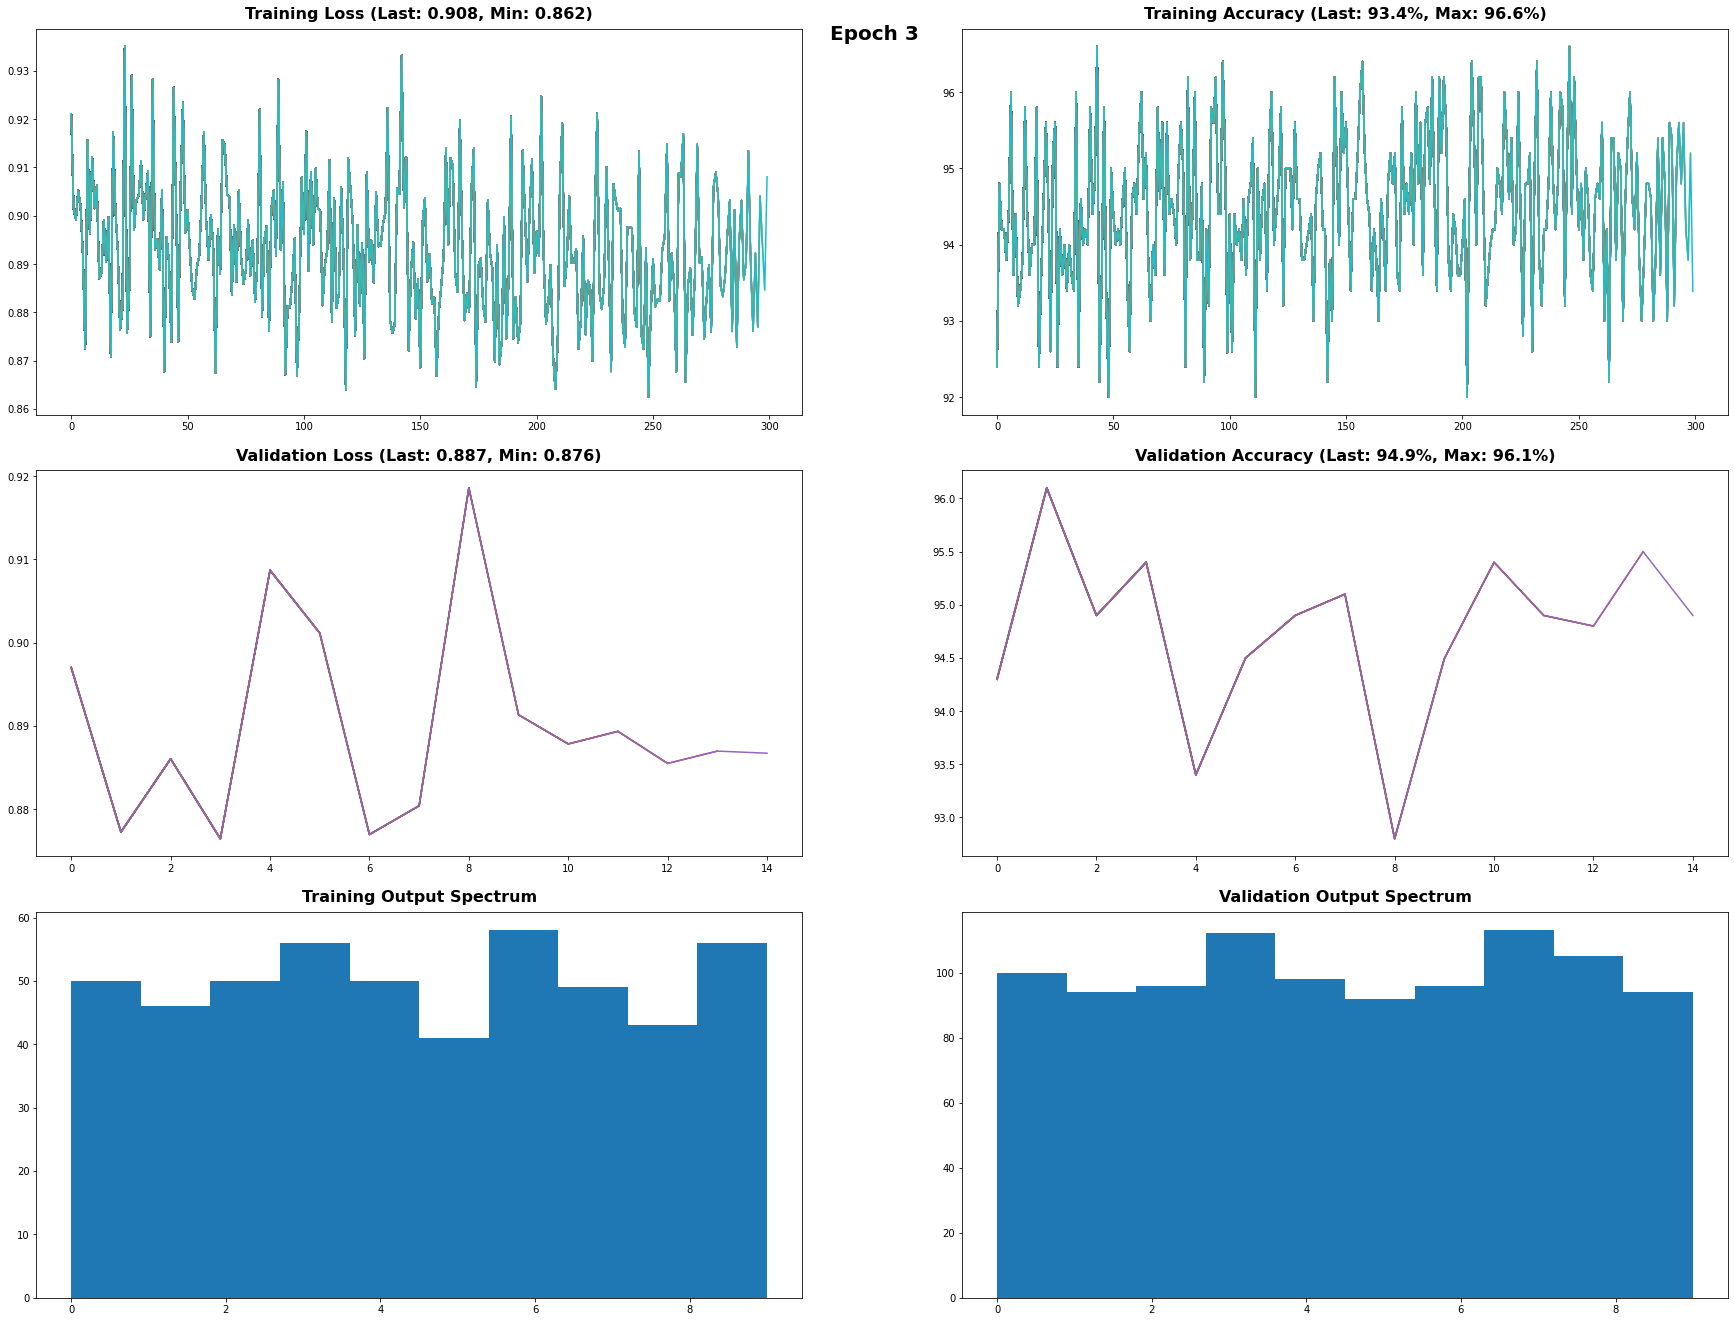

In [14]:
hype_second = Hyperparameters( \
    torch.optim.Adam(net.parameters(),lr=0.00001), \
    nn.CrossEntropyLoss()
    )

train_model(net, TrainingDashboard(), hype_second, stopping_initial, training_dataloader, validation_dataloader)

In [15]:
test_model(net,hype_second,test_dataloader)

Test Loss = 0.894, Test Accuracy = 94.4%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Save model for evaluation
torch.save(net.state_dict(),"MNistTrainedModel_A.pt")